# SemEval 2016 Slot1 Task: GloVe Average with Gold (target) Attention


This notebook is to make a baseline for slot1, aspect category detection. We use glove to generate sentence vector. 

Because we want to augment the embedding wegiht of target word to evaluate whether or not the attention is useful. 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/train.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/test.csv')

In [3]:
# Read data
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [4]:
def df2data(df):
    """Read data and labels from dataframe
    Input:
        df: three columns, ['Sentence #', 'Tag', 'Word']
    Output:
        data: datasize * ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        label: datasize * ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
    """
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    data = [[w[0] for w in s] for s in grouped]
    label = [[w[1] for w in s] for s in grouped]  
    
    return data, label

In [5]:
import xml.etree.ElementTree as ET
from collections import namedtuple
from collections import Counter


def read_targets(file_path):
    root = ET.parse(file_path)
    sentences = []
    class_targets = {}
    for review in root.findall("./Review"):
        for sentence in review.findall("./sentences/sentence"):
            targets = []
            for opinion in sentence.findall("./Opinions/Opinion"):
                target = opinion.attrib["target"]
                _class = opinion.attrib["category"]
                if target != "NULL":
                    targets.append(target)
                    if _class not in class_targets:
                        class_targets[_class] = Counter()
                    class_targets[_class][target] += 1
                
            sentences.append(targets)
                
    return sentences, class_targets

In [6]:
# load target words from npy
train_target_path = '../datasets/raw-semeval-2016/train.xml'
test_target_path = '../datasets/raw-semeval-2016/test.xml'

train_targets, train_class_targets = read_targets(train_target_path)
test_targets, test_class_targets = read_targets(test_target_path)
print(len(train_targets))
print(len(test_targets))
print(train_targets[:10])
print(train_class_targets["FOOD#QUALITY"].most_common()[:3])

2000
676
[['place'], ['staff'], [], ['food', 'portions'], [], ['place'], ['food'], ['Saul'], ['foie gras terrine with figs', 'duck confit'], ['wine list', 'wine list']]
[('food', 188), ('pizza', 20), ('sushi', 19)]


In [7]:
x_train_words, _ = df2data(data_train)
x_test_words, _ = df2data(data_test)

### embedding

In [9]:
def load_glove(file):
    """Loads GloVe vectors in numpy array.
    Args:
        file (str): a path to a glove file.
    Return:
        dict: a dict of numpy arrays.
    """
    model = {}
    with open(file, encoding="utf-8") as f:
        for line in f:
            line = line.split(' ')
            word = line[0]
            vector = np.array([float(val) for val in line[1:]])
            model[word] = vector

    return model

In [28]:
EMBEDDING_PATH = '../embedding_weights/glove.6B.300d.txt'

In [29]:
embeddings = load_glove(EMBEDDING_PATH)

Sum all to `word2vector_weighted` function, augment the weight if the word is target word

In [30]:
def word2vector_weighted(x_words, targets, weight=2, vector_size=200, verbose=False):

    sentence_vectors = []
    no_word_match = 0

    for sent, _targets in zip(x_words, targets):
        vector = []

        for word in sent:
            if embeddings.get(word) is None:
                continue

            e = embeddings[word]
            # simple method to match multiple target
            if sum([1 if word in t else 0 for t in _targets]) > 0:
                e = e * weight
            vector.append(e)

        if len(vector) > 0:
            sentence_vectors.append(np.mean(vector, axis=0))
        else:
            sentence_vectors.append(np.array([0] * vector_size))
            no_word_match += 1

    if verbose and no_word_match > 0:
        print("{} sentences does not match any pretrained vector.".format(no_word_match))

    return np.array(sentence_vectors)

In [40]:
def words2vector(x_words, vector_size=200):

    sentence_vectors = []
    no_word_match = 0

    for sent in x_words:
        vector = []
        for word in sent:
            if embeddings.get(word) is not None:
                vector.append(embeddings[word])
        if len(vector) > 0:
            sentence_vectors.append(np.mean(vector, axis=0))
        else:
            sentence_vectors.append(np.array([0] * vector_size))
            no_word_match += 1

    if no_word_match > 0:
        print("{} sentences does not match any pretrained vector.".format(no_word_match))

    return np.array(sentence_vectors)

In [41]:
x_train = words2vector(x_train_words, vector_size=300)
x_test = words2vector(x_test_words, vector_size=300)

1 sentences does not match any pretrained vector.


In [32]:
print(x_train.shape)
print(x_test.shape)

(2000, 300)
(676, 300)


### label 

this is a multicalss classification

In [33]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/train_label_df.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/test_label_df.csv')

In [34]:
y_train_df = pd.read_csv(train_path)
y_test_df = pd.read_csv(test_path)

In [35]:
y_train_df.head(3)

,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1


# model construct

In [36]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 160  520  880 1240 1600]
[CV]  ................................................................
[CV] ................................... , score=0.3775, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................................... , score=0.4175, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.435, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] ................................... , score=0.4675, total=   0.5s
[CV]  ................................................................
[CV] ................................... , score=0.4725, total=   0.7s
[CV]  ................................................................
[CV] ................................... , score=0.3175, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.4225, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4525, total=   0.3s
[CV]  ................................................................
[CV] ................................... , score=0.4625, total=   0.5s
[CV]  ................................................................
[CV] ..................................... , score=0.46, total=   0.7s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


[CV] ..................................... , score=0.41, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4075, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=0.4225, total=   0.5s
[CV]  ................................................................
[CV] ................................... , score=0.4375, total=   0.7s
[CV]  ................................................................
[CV] ................................... , score=0.3425, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.415, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4275, total=   0.3s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


[CV] ................................... , score=0.3875, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4225, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=0.4275, total=   0.5s
[CV]  ................................................................
[CV] ................................... , score=0.4425, total=   0.7s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.0s finished


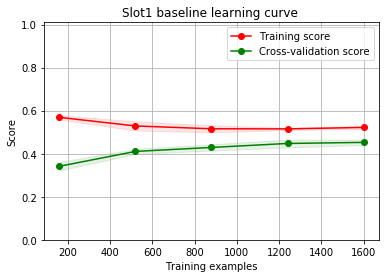

In [37]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ovr = OneVsRestClassifier(LogisticRegression())

plot_learning_curve(ovr, "Slot1 baseline learning curve ",
                    x_train, y_train_df, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


def calc_score(x_train, y_train, x_test, y_test):
    ovr = OneVsRestClassifier(LogisticRegression())
    ovr.fit(x_train, y_train)

    predicted = ovr.predict(x_test)
    score = f1_score(y_test, predicted, average="micro")
    return score

In [39]:
for w in [1, 1.5, 2, 2.5, 3]:
    x_train = word2vector_weighted(x_train_words, train_targets, weight=w, vector_size=300)
    x_test = word2vector_weighted(x_test_words, test_targets, weight=w, vector_size=300)
    s = calc_score(x_train, y_train_df, x_test, y_test_df)
    print("f1 score is {} when weight is {}".format(s, w))

f1 score is 0.5924713584288052 when weight is 1
f1 score is 0.6140209508460919 when weight is 1.5
f1 score is 0.6249008723235528 when weight is 2
f1 score is 0.631993695823483 when weight is 2.5
f1 score is 0.6378633150039278 when weight is 3



Baseline, no augment target word embedding, glove only
- `glove.6B.200d.txt`: 0.594
- `glove.840B.300d.txt`: 0.622


target augmented version
- `glove.6B.200d.txt`: 0.6337
```
f1 score is 0.5942386831275719 when weight is 1
f1 score is 0.6142625607779579 when weight is 1.5
f1 score is 0.6318327974276527 when weight is 2
f1 score is 0.6337579617834395 when weight is 2.5
f1 score is 0.632831086439334 when weight is 3
```



- `glove.6B.300d.txt`: 0.6378
```
f1 score is 0.5924713584288052 when weight is 1
f1 score is 0.6140209508460919 when weight is 1.5
f1 score is 0.6249008723235528 when weight is 2
f1 score is 0.631993695823483 when weight is 2.5
f1 score is 0.6378633150039278 when weight is 3
```


- `glove.840B.300d.txt`: 0.6506

```
f1 score is 0.6220095693779905 when weight is 1
f1 score is 0.6334125098970705 when weight is 1.5
f1 score is 0.6447058823529412 when weight is 2
f1 score is 0.6505836575875487 when weight is 2.5
f1 score is 0.6506211180124223 when weight is 3
```

# Add attention vector

## version 1 

This time we train the attention vector only use `semeval-2016/train.csv`. Due to the small dataset, we think the performance won't be good. 

version 1:
- vocab: 4000 

There are two way to use the attention vector:
- concatenate glove sentence vector and attention vector
- multiply glove sentence vector and attention vector 

In [151]:
train_att_sentences = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/train_att_sentences_v1.npy')
test_att_sentences = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/test_att_sentences_v1.npy')
train_att_weights = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/train_att_weights_v1.npy')
test_att_weights = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/test_att_weights_v1.npy')

In [152]:
train_att_sentences = np.load(train_att_sentences)
test_att_sentences = np.load(test_att_sentences)
train_att_weights = np.load(train_att_weights)
test_att_weights = np.load(test_att_weights)

In [155]:
# No scaler, only training data
s = calc_score(train_att_sentences, y_train_df, train_att_sentences, y_train_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))
# No scaler, training data and test data
s = calc_score(train_att_sentences, y_train_df, test_att_sentences, y_test_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.011299435028248588 when method is only sentence vector with attention score
f1 score is 0.003003003003003003 when method is only sentence vector with attention score


In [156]:
# Standarlization
scaler = StandardScaler().fit(train_att_sentences) 
x_scaler = scaler.transform(train_att_sentences)
x_scaler_test = scaler.transform(test_att_sentences)

s = calc_score(x_scaler, y_train_df, x_scaler, y_train_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

s = calc_score(x_scaler, y_train_df, x_scaler_test, y_test_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.41768131286394916 when method is only sentence vector with attention score
f1 score is 0.2057091073855913 when method is only sentence vector with attention score


In [133]:
# Normalization, axis = 0, 1
from sklearn.preprocessing import normalize
for axis in [0, 1]:
    x_scaler = normalize(train_att_sentences, axis=axis) 
    s = calc_score(x_scaler, y_train_df, x_scaler, y_train_df)
    print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.0037821482602118004 when method is only sentence vector with attention score
f1 score is 0.05122575923893158 when method is only sentence vector with attention score


In [119]:
scaler = StandardScaler().fit(train_att_sentences) 
x_scaler = scaler.transform(train_att_sentences)

In [122]:
s = calc_score(train_att_sentences, y_train_df, train_att_sentences, y_train_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.011299435028248588 when method is only sentence vector with attention score


In [102]:
from sklearn.preprocessing import StandardScaler

def preprocessing(x_train, x_test, att_train_feature=None, att_test_feature=None, method='no'):
    # Load attention data and normalize 
    if method == 'concat':
        x_train = np.concatenate((x_train, att_train_feature), axis=1)
        x_test = np.concatenate((x_test, att_test_feature), axis=1)
    elif method == 'multiply':
        x_train = np.multiply(x_train, att_train_feature)
        x_test = np.multiply(x_test, att_test_feature)
    elif method == 'plus':
        x_train = x_train + att_train_feature
        x_test = x_test + att_test_feature
    else:
        x_train = att_train_feature
        x_test = att_test_feature
    
    scaler = StandardScaler().fit(x_train) 
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    return x_train, x_test

In [114]:
# v1 
x_train_v1_concat, x_test_v1_concat = preprocessing(x_train, x_test, train_att_sentences, test_att_sentences, method='concat')
x_train_v1_multiply, x_test_v1_multiply = preprocessing(x_train, x_test, train_att_sentences, test_att_sentences, method='multiply')
x_train_v1_sentence, x_test_v1_sentence = preprocessing(x_train, x_test, train_att_sentences, test_att_sentences, method='plus')

In [115]:
s = calc_score(x_train, y_train_df, x_test, y_test_df)
print("f1 score is {} when method is {}".format(s, 'baseline(only glove)'))
s = calc_score(x_train_v1_concat, y_train_df, x_test_v1_concat, y_test_df)
print("f1 score is {} when method is {}".format(s, 'concat'))
s = calc_score(x_train_v1_multiply, y_train_df, x_test_v1_multiply, y_test_df)
print("f1 score is {} when method is {}".format(s, 'multiply'))
s = calc_score(x_train_v1_sentence, y_train_df, x_test_v1_sentence, y_test_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.5924713584288052 when method is baseline(only glove)
f1 score is 0.44509803921568625 when method is concat
f1 score is 0.34560906515580736 when method is multiply



## version 2

This time we train the attention vector by using original text dataset, `source = '../preprocessed_data/restaurant/train.txt'`. This dataset contains 279859 training examples. 


version 1:
- vocab: 45000

There are two way to use the attention vector:
- concatenate glove sentence vector and attention vector
- multiply glove sentence vector and attention vector 

In [141]:
train_att_sentences = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/train_att_sentences_v2.npy')
test_att_sentences = Path.cwd().parent.joinpath('code/output_dir/semeval-2016/test_att_sentences_v2.npy')

train_att_sentences = np.load(train_att_sentences)
test_att_sentences = np.load(test_att_sentences)

In [149]:
# No scaler, only training data
s = calc_score(train_att_sentences, y_train_df, train_att_sentences, y_train_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))
# No scaler, training data and test data
s = calc_score(train_att_sentences, y_train_df, test_att_sentences, y_test_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.15698478561549103 when method is only sentence vector with attention score
f1 score is 0.18610747051114024 when method is only sentence vector with attention score


OMG! This is weird!

In [145]:
# Standarlization
scaler = StandardScaler().fit(train_att_sentences) 
x_scaler = scaler.transform(train_att_sentences)
# training on training data and test on training data
s = calc_score(x_scaler, y_train_df, x_scaler, y_train_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.7078727723889016 when method is only sentence vector with attention score


In [146]:
# Standarlization
scaler = StandardScaler().fit(train_att_sentences) 
x_scaler = scaler.transform(train_att_sentences)
x_scaler_test = scaler.transform(test_att_sentences)
# training on training data and test on test data
s = calc_score(x_scaler, y_train_df, x_scaler_test, y_test_df)
print("f1 score is {} when method is {}".format(s, 'only sentence vector with attention score'))

f1 score is 0.5182926829268293 when method is only sentence vector with attention score
